In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
np.random.seed(123456789)   # repeatable results
import matplotlib.pyplot as pl
import matplotlib.mlab as mlab
import scipy.signal as sig
import scipy.constants as const
from scipy import interpolate
import corner
import emcee as mc
import pickle

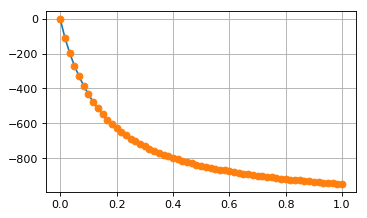

In [2]:
### Load comsol model for thermal lens
# Comsol model of the self heating
model = np.loadtxt('1W_self_heating_defocus_doublepass.txt')

time_model = model[:,0]
abs_model  = model[:,1]

def TL(x,a,b):    
    y = interpolate.interp1d(time_model,-abs_model,fill_value="extrapolate")
    ynew = y(x)
    return a + (b * ynew)

a=0.0
b=1.0
x = np.arange(0,1,.001) #hours
f = TL(x,a,b)

#### Plot
pl.figure(figsize=(5, 3), dpi=80)
pl.plot(x,f)
pl.plot(time_model,-abs_model, 'o')
pl.grid()
pl.show()

In [21]:
### Best guess for ITM
### Test on ITMX numberst
amp_guess_x  =  -5.85791125 #Starting Amplitude Guess
tau_guess_x = 5.02301549e-02 # Decay Time guess

print('amp_model_x = ', amp_guess_x, 'udiopters')
print('tau_model_x = ', tau_guess_x, 'hours')

amp_guess_y  =  10 #Starting Amplitude Guess
tau_guess_y = 1.17276522e-01 # Decay Time guess

print('amp_model_y = ', amp_guess_y, 'udiopters')
print('tau_model_y = ', tau_guess_y, 'hours')

amp_model_x =  -5.85791125 udiopters
tau_model_x =  0.0502301549 hours
amp_model_y =  10 udiopters
tau_model_y =  0.117276522 hours


In [22]:
### Load the HWS Data
itmx = 'data_ITMX.p'
itmy = 'data_ITMY.p'

i_ind_x = 80
e_ind_x = -1
c_hori_x = 700
c_vert_x = 450


i_ind_y = 40
e_ind_y = -1
c_hori_y = 700
c_vert_y = 560


def open_file(filename):
    with open(str(filename), 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        data_p = u.load()
    return data_p

def format_data(optic, i_ind, e_ind,x,y):
    optic_data_p = open_file(optic)
    optic_data = optic_data_p[(x,y)]['spherical']
    
    data = optic_data[ i_ind_x:e_ind_x ]*1e6
    
    data = data - data[0]
    
    t_vect = np.arange(0.,float(len(data)),1.)
    t_vect = (t_vect)*20/3600 # Convert to Hours
    t_vect = t_vect - t_vect[0]
    
    return t_vect, data
   

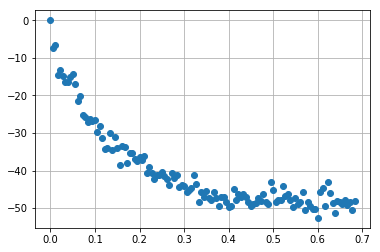

In [23]:
time_x, data_x = format_data(itmx, i_ind_x, e_ind_x, c_hori_x , c_vert_x)
pl.plot(time_x, data_x, 'o')
pl.grid()

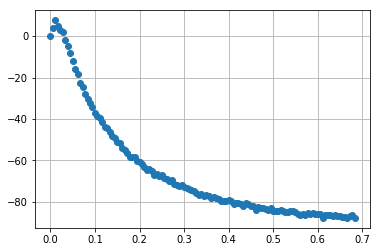

In [24]:
time_y, data_y = format_data(itmy, i_ind_y, e_ind_y, c_hori_y , c_vert_y)
pl.plot(time_y, data_y, 'o')
pl.grid()

In [25]:
# Define Log Likelihood
def lnprob(theta, t, signal, uncs) :
    amplitude = theta[0]
    tau = theta[1]
    
    if amplitude <= -30.0 or amplitude > 30.0 or a <= -1.0 or a > 1.0 :
        return -np.inf
    else :
        new_signal = TL(t,amplitude,tau)
        return -np.sum(np.abs(signal - new_signal)**2/(2*np.square(uncs)))

In [26]:
def run_mcmc(t_vect, data, amp_guess, tau_guess):
    ndim = 2
    nwalkers = 100
    rr = np.transpose(np.vstack([np.random.normal(-1.0, 1.0, nwalkers),
                                 np.random.normal(0, 5.0, nwalkers) ]))
    p0 = np.tile(np.array([amp_guess, tau_guess]), (nwalkers,1)) + rr
    rr[0]

    samp = mc.EnsembleSampler(nwalkers, ndim, lnprob, args=[t_vect, data, uncs])

    pos, prob, state = samp.run_mcmc(p0, 100)
    samp.reset()

    samp.run_mcmc(pos, 500);

    results = np.copy(samp.flatchain) 
    
    return results

def plot_results(t_vect, signal, results):
    amp_mean, a_mean = np.mean(results,axis=0)
    amp_median, a_median = np.median(results,axis=0)
    covmat = np.cov(results.T)
    amp_unc, a_unc = np.sqrt(np.diag(covmat))
    print("Means         = ", amp_mean, a_mean)
    print("Medians       = ",amp_median, a_median)
    print("Uncertainties = ",amp_unc, a_unc)
    print(covmat)

    recovered_exp = TL(t_vect,amp_median,a_median)
    
    pl.figure(figsize=(10, 5), dpi=300)
    pl.plot(t_vect, np.real(recovered_exp), '--',label='Recovered exponential function')
    pl.plot(t_vect, signal, 'o', label='Noisy exponential function')
    pl.legend(loc='best')
    pl.xlabel('Time [Hours]')
    pl.ylabel('Spherical Power [microdiopters]')
    pl.grid()

In [27]:
noise_std = 30.0
uncs = noise_std * np.ones(len(time_x))  # Uniform uncertainty in each point
results_x = run_mcmc(time_x,data_x, amp_guess_x, tau_guess_x)

Quantiles:
[(0.16, -14.697043165630046), (0.5, -6.387737318205534), (0.84, 2.354147740801541)]
Quantiles:
[(0.16, 0.03782720383495304), (0.5, 0.049444239374863835), (0.84, 0.061651896620050356)]


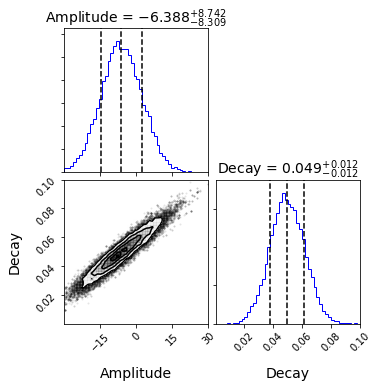

In [28]:
range_list = [ [-30, 30], [0.0, 0.1] ]
h_c = corner.corner(results_x, 
                    bins=50, 
                    labels=['Amplitude', 'Decay'],
                    label_kwargs={'fontsize':14},
                    show_titles=True,
                    title_kwargs={'fontsize':14},
                    title_fmt='.3f' ,
                    quantiles=[0.16, 0.5, 0.84],
                    range=range_list,
                    verbose=True,
                    hist_kwargs={'color':'b'})
#h_c.savefig("SineGaussianTrianglePlots.pdf")

Means         =  -6.19804338003621 0.04970209782520747
Medians       =  -6.387737318205534 0.049444239374863835
Uncertainties =  8.540600037054244 0.011936230898838116
[[7.29418490e+01 9.66128985e-02]
 [9.66128985e-02 1.42473608e-04]]


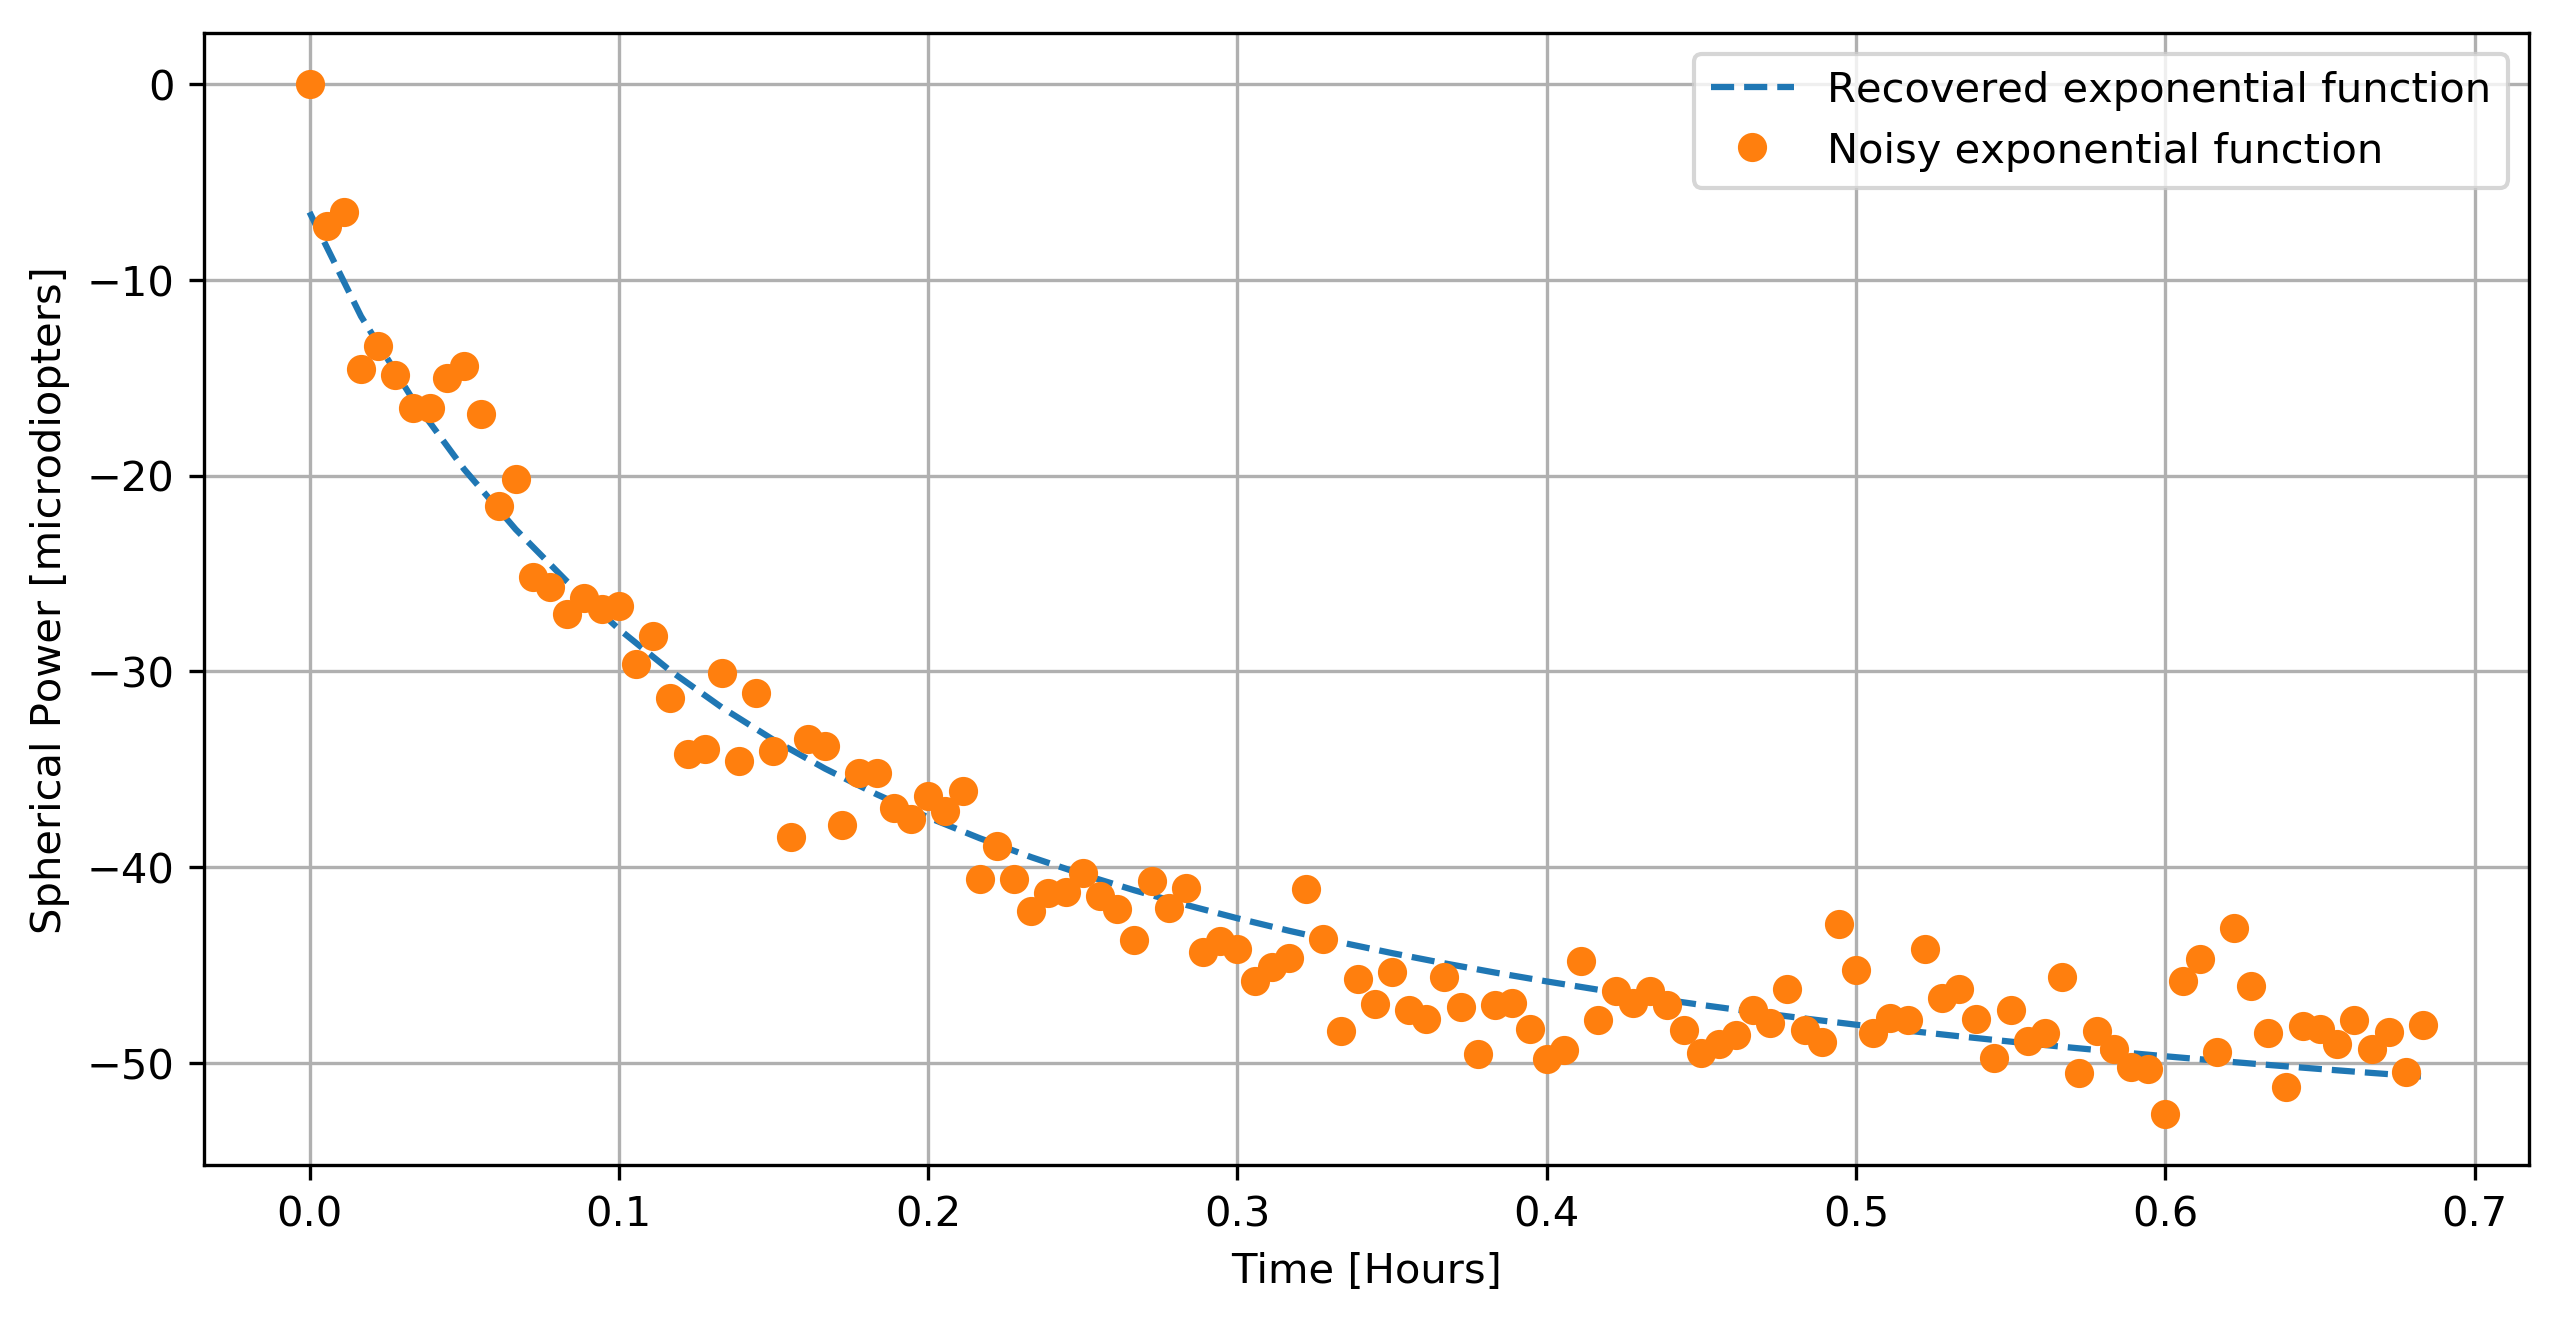

In [29]:
plot_results(time_x,data_x,results_x)

In [30]:
noise_std = 30.0
#uncs = noise_std * np.ones(len(time_y))  # Uniform uncertainty in each point
results_y = run_mcmc(time_y,data_y, amp_guess_y, tau_guess_y)

Quantiles:
[(0.16, 5.470966960169979), (0.5, 14.003837612233008), (0.84, 22.141569978756415)]
Quantiles:
[(0.16, 0.10466346742437835), (0.5, 0.1164948880887398), (0.84, 0.1279366448344377)]


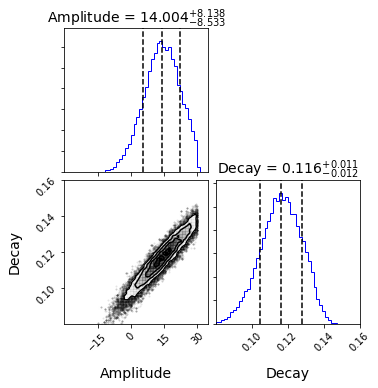

In [31]:
range_list = [ [-30, 35], [0.08, 0.16] ]
h_c = corner.corner(results_y, 
                    bins=50, 
                    labels=['Amplitude', 'Decay'],
                    label_kwargs={'fontsize':14},
                    show_titles=True,
                    title_kwargs={'fontsize':14},
                    title_fmt='.3f' ,
                    quantiles=[0.16, 0.5, 0.84],
                    range=range_list,
                    verbose=True,
                    hist_kwargs={'color':'b'})
#h_c.savefig("SineGaussianTrianglePlots.pdf")

Means         =  13.712249881026683 0.11612752994124308
Medians       =  14.003837612233008 0.1164948880887398
Uncertainties =  8.073058702115315 0.011385262152715476
[[6.51742768e+01 8.66646418e-02]
 [8.66646418e-02 1.29624194e-04]]


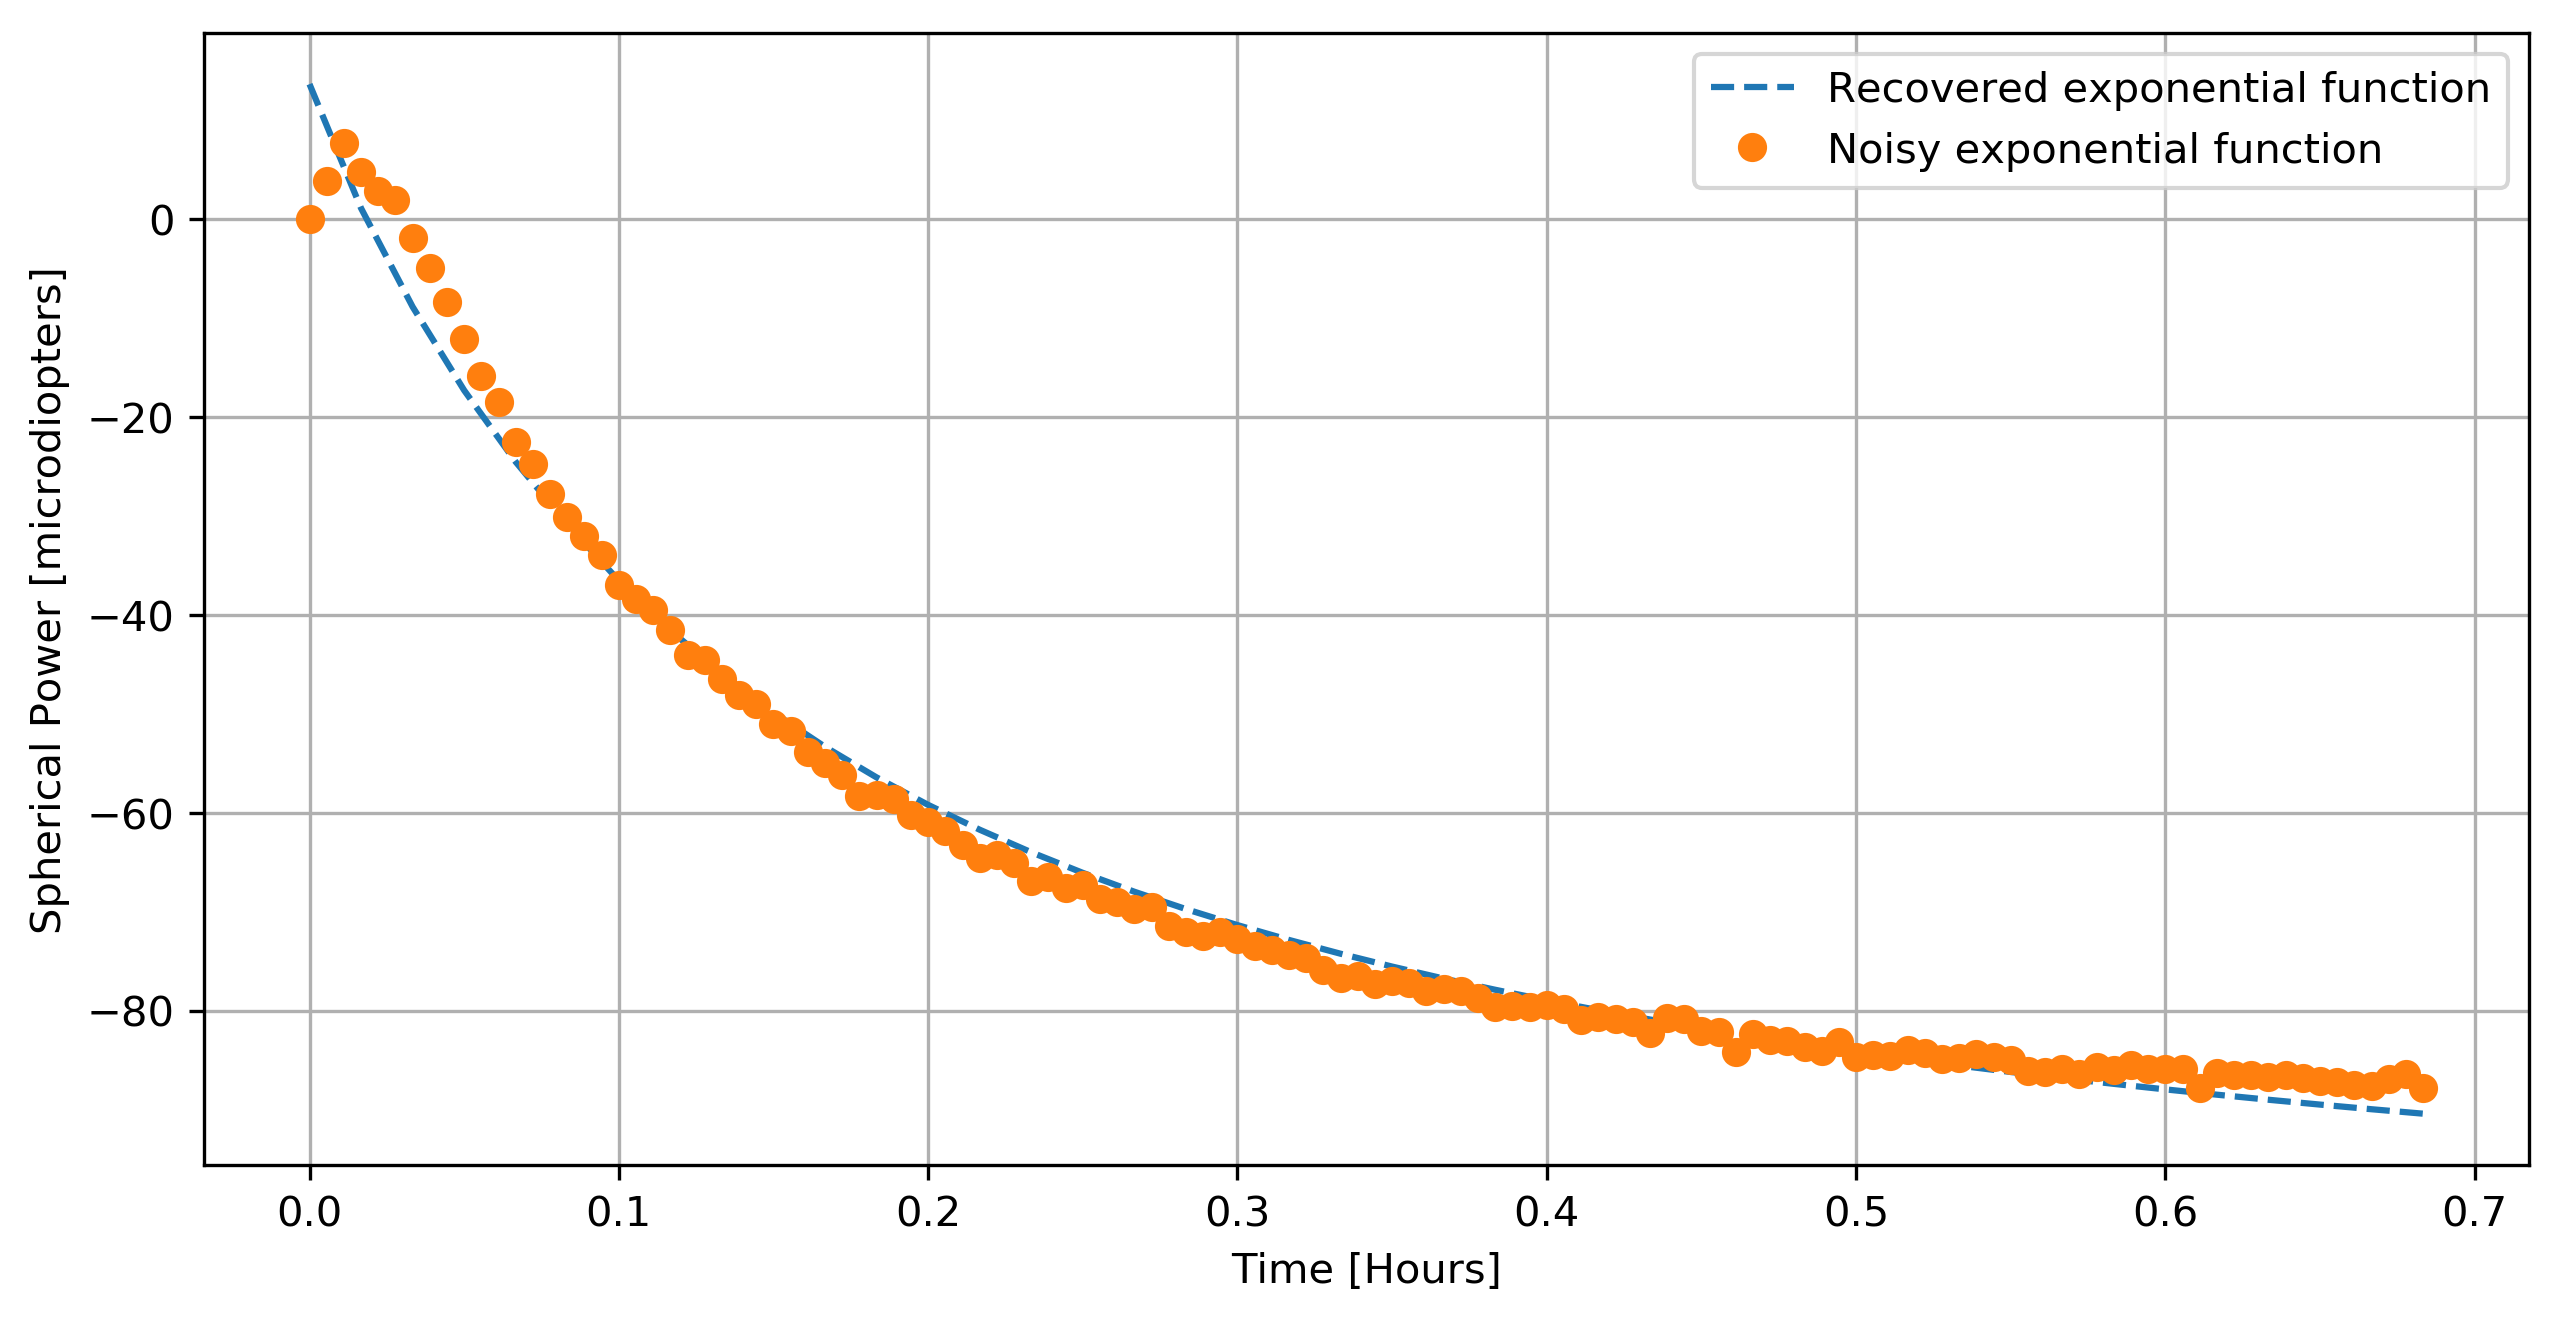

In [32]:
plot_results(time_y,data_y,results_y)